## Reddit Post Natural Language Processing and Classification
![reddit](images/reddit_logo.png)
### 03. Modeling




In [192]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

Read in cleaned data from csv file.

In [193]:
posts_df = pd.read_csv('data/clean_posts.csv')
posts_df.head()

,subreddit,selftext,title,author,created_utc,created_date,all_text,class
0,AskCulinary,"Hi everyone,\n\nI'm not sure if this is the pl...",Fridge for an instructional kitchen?,PrinceOfWales_,1610056955,2021-01-07 22:02:35,"Hi everyone, I'm not sure if this is the plac...",1
1,AskCulinary,"Hey, I was wondering if anybody had tips to ke...",How to keep sourdough starter jar clean?,frowogger,1610055394,2021-01-07 21:36:34,"Hey, I was wondering if anybody had tips to ke...",1
2,AskCulinary,\nI’m Gonna make birria tacos tomorrow and my ...,What substitutes can I use for guajillo chili’...,pelse_O_clock,1610055301,2021-01-07 21:35:01,I’m Gonna make birria tacos tomorrow and my g...,1
3,AskCulinary,"Hi all,\n\nI just found a steal on a WagnerWar...",Wagner Magnalite Dutch Oven,EmbryoRoux,1610055100,2021-01-07 21:31:40,"Hi all, I just found a steal on a WagnerWare ...",1
4,AskCulinary,"Hi all,\n\nI tried making Julia's recipe for P...",AWFUL SMELL Potage Parmentier/Vichyssoise,batcat03,1610054738,2021-01-07 21:25:38,"Hi all, I tried making Julia's recipe for Pot...",1


In [194]:
posts_df.shape

(17847, 8)

After cleaning and performing EDA, the data set contains close to 18_000 posts.

55% of the rows are in the **Ask Culinary** subreddit.
45% of the rows are in the **running** subreddit.

This is still fairly balanced, but is due to the fact that many rows in running had to be dropped due to being removed, or containing junk data.


In [195]:
X = posts_df['all_text']
y = posts_df['class']
y.value_counts(normalize=True)

1    0.547207
0    0.452793
Name: class, dtype: float64

In [196]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=21)

### Create Three Models
1. Pipeline with:
* CountVectorizer (transformer)
* Multinomial Naive Bayes (estimator)

2. Pipeline with:
* TfidfVectorizer (transformer)
* KNeighborsClassifier (estimator)

3. Pipeline with:
* CountVectorizer (transformer)
* Random Forest (estimator)



--- 
#### 1. Pipeline with:
* CountVectorizer (transformer)
* Multinomial Naive Bayes (estimator)

Code borrowed heavily from class lecture 5.04

In [197]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [198]:
# Add stop words that might be measurements for recipes, and distance for running (km)
# hat tip to for adding custom stop words : https://stackoverflow.com/a/24386751/732396

# the most common words in the running subreddit were, not surprisingly, run and running, so take
# those out

# After our EDA, add 'just' and 'like', which were the two most common words
added_stop_words = ['oz', 'cups', 'km', 'run', 'running', 'just', 'like']
stop_words_list = text.ENGLISH_STOP_WORDS.union(added_stop_words)

The word **'alone'** is in the default stop words file, but this is something I am trying to research for my problem statement. So remove it from the list of stop_words.

The sklearn ENGLISH_STOP_WORDS is a frozenset, so a value can not be easily removed.<br>
Instead, make a copy into a new list, then remove the word 'alone'.

This is explained in more detail in the 04 Sentiment notebook.

In [199]:
unfrozen_stop_words = [word for word in stop_words_list]
unfrozen_stop_words.remove('alone')

In [200]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens, 2-grams and 3-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words' : [unfrozen_stop_words]
}

# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5, n_jobs = -1, verbose=1)

# Fit GridSearch to training data.
gs.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.0min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['already', 'whither', 'it',
                                               'and', 'been', 'empty', 'within',
                                               'neither', 'you', 'interest',
                                               'anyone', 'throughout', 'namely',
                                               'via', 'twenty', 'almost', 'co',
                                               'everywhere', 'thence', 'though',
                                               'noone', 'cannot', 'thus', 'no',
                    

In [201]:
# What's the best score?
print(gs.best_score_)

0.9918874290294288


#### What were the best performing parameters?

In [202]:
# Creating a list to avoid printing the entire list of stop words
print(list(gs.best_params_.keys())[0:4])
print(list(gs.best_params_.values())[0:4])

['cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range']
[0.9, 4000, 3, (1, 1)]


In [203]:
# Score model on training set.
print (f'Training model score: {gs.score(X_train, y_train)} ')

# Score model on testing set.
print (f'Testing model score: {gs.score(X_test, y_test)} ')

Training model score: 0.9924730283515932 
Testing model score: 0.9908319185059423 


In [204]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

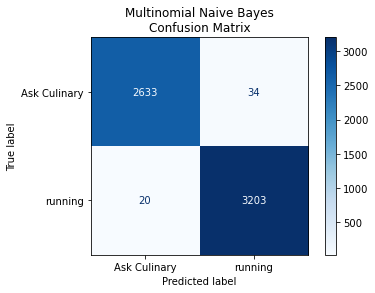

In [229]:
disp = plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d',display_labels=['Ask Culinary', 'running']);
disp.ax_.set_title("Multinomial Naive Bayes\nConfusion Matrix");

---
#### 2. Pipeline with:
* TfidfVectorizer (transformer)
* KNeighborsClassifier (estimator)


Code borrowed heavily from class lecture 5.04

In [206]:
simple_tvec = TfidfVectorizer(stop_words = more_stop_words)

transformed_df = simple_tvec.fit_transform(X_train)
transformed_df.shape

(11957, 24598)

The TF-IDF vectorizer creates 14,558 feature columns.

In [207]:
# Set up a pipeline with tf-idf vectorizer and K nearest neighbor

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [208]:
pipe_tvec_params = {
    'tvec__max_features': [4_000, 6_000, 8_000, 10_000],
    'tvec__stop_words': [unfrozen_stop_words],
    'tvec__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': range(7, 149, 10),
    'knn__metric': ['euclidean', 'manhattan'],
    'knn__weights' : ['uniform', 'distance'],
}

# Instantiate GridSearchCV.
gs_tvec = GridSearchCV(pipe_tvec,
                    param_grid = pipe_tvec_params, 
                    cv=5,
                    n_jobs = -1,
                    verbose=1) 

# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 17.1min
[Parallel(n_jobs=-1)]: Done 2400 out of 2400 | elapsed: 28.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan'],
                         'knn__n_neighbors': range(7, 149, 10),
                         'knn__weights': ['uniform', 'distance'],
                         'tvec__max_features': [4000, 6000, 8000, 10000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [['already', 'whither', 'it',
                                               'and', 'been', 'empty', 'within',
                                               'neither', 'you', 'interest',
                                               'anyone', 'throughout', 'namely',
                                               'via', 'twenty', 'almost', 'co',
                                               'everywhere', 'thence', 'though',
    

#### What were the best performing parameters?

In [216]:
# Creating a list to avoid printing the entire list of stop words
print(list(gs_tvec.best_params_.keys())[0:5])
print(list(gs_tvec.best_params_.values())[0:5])

['knn__metric', 'knn__n_neighbors', 'knn__weights', 'tvec__max_features', 'tvec__ngram_range']
['euclidean', 147, 'distance', 10000, (1, 2)]


In [210]:
# What's the best score?
print(f'Best score: {gs_tvec.best_score_}')

# Score model on training set.
print (f'Training model score: {gs_tvec.score(X_train, y_train)} ')

# Score model on testing set.
print (f'Testing model score: {gs_tvec.score(X_test, y_test)} ')

Best score: 0.9859495404310199
Training model score: 1.0 
Testing model score: 0.9867572156196944 


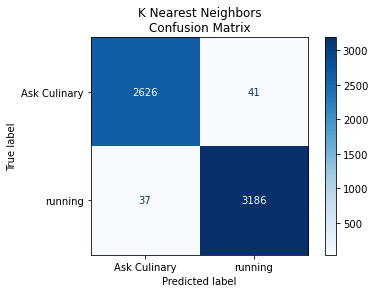

In [227]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

disp = plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d',display_labels=['Ask Culinary', 'running'])
disp.ax_.set_title("K Nearest Neighbors\nConfusion Matrix");

---
#### 3. Pipeline with:
* CountVectorizer (transformer)
* Random Forest (estimator)

In [212]:
forest_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('forest', RandomForestClassifier())
])

forest_pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'forest__n_estimators': [20, 60, 100, 300 ,400],
    'forest__max_depth': [4, 10, 20],
    'cvec__stop_words' : [unfrozen_stop_words]
}

forest_gs = GridSearchCV(forest_pipe, param_grid=forest_pipe_params, cv=5, n_jobs = -1, verbose=1)

# Fit GridSearch to training data.
forest_gs.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed: 22.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('forest', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['already', 'whither', 'it',
                                               'and', 'been', 'empty', 'within',
                                               'neither', 'you', 'interest',
                                               'anyone', 'throughout', 'namely',
                                               'via', 'twenty', 'almost', 'co',
                                               'everywhere', 'thence', 'though',
                                               'noone', 'cannot', 'thus', 'no',
       

#### What were the best performing parameters?

In [213]:
# Creating a list to avoid printing the entire list of stop words
print(list(forest_gs.best_params_.keys())[0:4] +  list(forest_gs.best_params_.keys())[5:7])
print(list(forest_gs.best_params_.values())[0:4] +  list(forest_gs.best_params_.values())[5:7])

['cvec__max_df', 'cvec__max_features', 'cvec__min_df', 'cvec__ngram_range', 'forest__max_depth', 'forest__n_estimators']
[0.95, 3000, 2, (1, 1), 20, 400]


In [214]:
# What's the best score?
print(f'Best score: {forest_gs.best_score_}')

# Score model on training set.
print (f'Training model score: {forest_gs.score(X_train, y_train)} ')

# Score model on testing set.
print (f'Testing model score: {forest_gs.score(X_test, y_test)} ')

Best score: 0.9403696134752814
Training model score: 0.9458058041314711 
Testing model score: 0.9388794567062818 


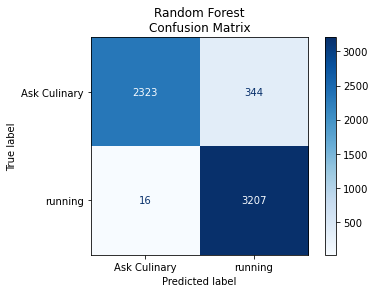

In [228]:
# Get predictions
preds_forest = forest_gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_forest).ravel()

disp = plot_confusion_matrix(forest_gs, X_test, y_test, cmap='Blues', values_format='d',display_labels=['Ask Culinary', 'running'])
disp.ax_.set_title("Random Forest\nConfusion Matrix");